# 🎯 Playlist Analysis & Clustering

Deep dive into your **owned playlists** with genre analysis and similarity clustering.

**Prerequisites:** Run `01_sync_data.ipynb` first.

**Features:**
- 🏷️ Genre breakdown per playlist
- 🔗 Playlist similarity clustering
- 👤 Your taste profile
- 🎯 Find similar playlists (including followed!)

**⚙️ Modular Filtering:** Configure which playlists to analyze below!

## ⚙️ Configuration

**Edit the filters below to customize your analysis!**

In [ ]:
# ============================================================================
# 🎛️ ANALYSIS FILTERS - Edit these to customize your analysis!
# ============================================================================

# Exclude special playlists from analysis
EXCLUDE_LIKED_SONGS = True    # Set True to exclude Liked Songs master playlist
EXCLUDE_MONTHLY = False        # Set True to exclude monthly playlists (Jan'25, etc.)

# Analyze only specific playlists by name (leave empty [] for all owned playlists)
INCLUDE_ONLY_PLAYLISTS = []

# Exclude specific playlists by name
EXCLUDE_PLAYLISTS = []

# ============================================================================
# 🔗 SIMILARITY SEARCH OPTIONS
# ============================================================================

# When finding similar playlists, which playlists to search in?
# Options: "followed_only", "owned_only", "all"
SIMILAR_SEARCH_MODE = "followed_only"

print("✅ Configuration loaded!")
print(f"   • Exclude Liked Songs: {EXCLUDE_LIKED_SONGS}")
print(f"   • Exclude Monthly: {EXCLUDE_MONTHLY}")
print(f"   • Similar search mode: {SIMILAR_SEARCH_MODE}")

✅ Configuration loaded!
   • Exclude Liked Songs: True
   • Exclude Monthly: True
   • Similar search mode: followed_only


## 1️⃣ Setup

In [2]:
# Install dependencies
%pip install -q pandas numpy matplotlib seaborn scikit-learn pyarrow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

# Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Style
plt.style.use('dark_background')
sns.set_palette("husl")

DATA_DIR = Path("..") / "data"
print(f"📁 Loading data from: {DATA_DIR.resolve()}")

📁 Loading data from: /Users/aryamaan/Desktop/Projects/spotim8_repo/data


## 2️⃣ Load Data (Owned Playlists Only)

In [ ]:
# Import shared utilities
from spotim8.analysis import LibraryAnalyzer, get_genres_list, build_playlist_genre_profiles

# Load and filter data
try:
    analyzer = LibraryAnalyzer(DATA_DIR).load()
    analyzer.filter(
        exclude_liked=EXCLUDE_LIKED_SONGS,
        exclude_monthly=EXCLUDE_MONTHLY,
        include_only=INCLUDE_ONLY_PLAYLISTS if INCLUDE_ONLY_PLAYLISTS else None,
        exclude_names=EXCLUDE_PLAYLISTS if EXCLUDE_PLAYLISTS else None
    )
    
    # Convenience references
    playlists = analyzer.playlists
    playlists_all = analyzer.playlists_all  # Keep all for similarity search
    tracks = analyzer.tracks
    artists = analyzer.artists
    playlist_tracks = analyzer.playlist_tracks
    playlist_tracks_all = analyzer.playlist_tracks_all
    track_artists = analyzer.track_artists
except FileNotFoundError as e:
    print(f"❌ {e}")
    raise

✅ Loaded 555 playlists, 5,232 tracks
   ✗ Excluded Liked Songs
   ✗ Excluded 10 monthly playlists

📊 Analysis scope:
   115 playlists | 3,811 tracks | 2,138 artists


## 3️⃣ Build Genre Profiles

In [5]:
# Build track -> genres mapping (via primary artist)
# Note: get_genres_list is imported from lib.py
primary_artists = track_artists[track_artists["position"] == 0].copy()
track_genres = primary_artists.merge(artists[["artist_id", "genres"]], on="artist_id")
track_genres["genres_list"] = track_genres["genres"].apply(get_genres_list)

# Build playlist -> genre profile using shared utility
playlist_genre_profiles = build_playlist_genre_profiles(
    playlists, playlist_tracks, track_artists, artists
)

print(f"✅ Built profiles for {len(playlist_genre_profiles)} playlists")

✅ Built profiles for 113 playlists


## 4️⃣ Genre Breakdown by Playlist

In [6]:
def show_playlist_genres(playlist_name, top_n=10):
    """Display top genres for a playlist."""
    pid = playlists[playlists["name"] == playlist_name]["playlist_id"]
    if len(pid) == 0:
        print(f"❌ Playlist '{playlist_name}' not found")
        return
    
    genres = playlist_genre_profiles.get(pid.iloc[0], Counter())
    if not genres:
        print(f"No genres found for '{playlist_name}'")
        return
    
    print(f"\n🎵 {playlist_name} - Top {top_n} Genres:")
    print("-" * 45)
    total = sum(genres.values())
    for genre, count in genres.most_common(top_n):
        pct = count / total * 100
        bar = "█" * int(pct / 2)
        print(f"   {genre:28} {bar} {pct:.1f}%")

# Show genres for top 5 owned playlists
print("📊 GENRE BREAKDOWN BY OWNED PLAYLIST")
for _, row in playlists.nlargest(5, "track_count").iterrows():
    show_playlist_genres(row["name"])

📊 GENRE BREAKDOWN BY OWNED PLAYLIST

🎵 SandTrap 🏝️🇹🇭 - Top 10 Genres:
---------------------------------------------
   rap                          ██████ 12.4%
   melodic rap                  ██ 4.8%
   r&b                          █ 3.8%
   grime                        █ 3.2%
   uk grime                     █ 2.9%
   desi                         █ 2.7%
   alternative r&b              █ 2.5%
   indian indie                 █ 2.5%
   bedroom pop                  █ 2.2%
   hindi indie                  █ 2.2%

🎵 Sunhop ☀️ - Top 10 Genres:
---------------------------------------------
   rap                          █████████ 18.1%
   grime                        ████ 9.7%
   uk grime                     ████ 9.4%
   melodic rap                  ███ 6.2%
   uk drill                     ██ 5.9%
   drill                        ██ 5.6%
   hip hop                      █ 3.8%
   jazz rap                     █ 3.3%
   dark r&b                     █ 3.2%
   r&b                          █ 2.7%

🎵

## 5️⃣ Playlist Similarity & Clustering

In [7]:
# Get all unique genres
all_genres = set()
for genres in playlist_genre_profiles.values():
    all_genres.update(genres.keys())
all_genres = sorted(list(all_genres))

print(f"📊 Found {len(all_genres)} unique genres in owned playlists")

# Create normalized genre vector for each playlist
def playlist_to_vector(pid):
    genres = playlist_genre_profiles.get(pid, Counter())
    total = sum(genres.values()) or 1
    return [genres.get(g, 0) / total for g in all_genres]

# Build feature matrix
playlist_ids = playlists["playlist_id"].tolist()
playlist_names = playlists.set_index("playlist_id")["name"].to_dict()

X = np.array([playlist_to_vector(pid) for pid in playlist_ids])

# Filter out empty playlists
non_empty = X.sum(axis=1) > 0
X_filtered = X[non_empty]
playlist_ids_filtered = [pid for pid, ne in zip(playlist_ids, non_empty) if ne]

print(f"✅ Feature matrix: {X_filtered.shape[0]} owned playlists × {X_filtered.shape[1]} genres")

📊 Found 311 unique genres in owned playlists
✅ Feature matrix: 115 owned playlists × 311 genres


In [ ]:
from spotim8.analysis import PlaylistSimilarityEngine

# Build similarity engine
similarity_engine = PlaylistSimilarityEngine(analyzer)
similarity_engine.build(include_followed=True)  # Build with all playlists

print(f"📊 Built similarity index with {len(similarity_engine._playlist_ids)} playlists")

def find_similar_playlists(playlist_name, top_n=5, mode=None):
    """Find playlists most similar to the given one.
    
    Args:
        playlist_name: Name of the source playlist
        top_n: Number of results
        mode: Override for SIMILAR_SEARCH_MODE ("followed_only", "owned_only", "all")
    """
    mode = mode or SIMILAR_SEARCH_MODE
    
    # Find playlist ID
    match = playlists[playlists["name"] == playlist_name]
    if len(match) == 0:
        # Try all playlists
        match = playlists_all[playlists_all["name"] == playlist_name]
    
    if len(match) == 0:
        print(f"❌ Playlist '{playlist_name}' not found")
        return []
    
    playlist_id = match.iloc[0]["playlist_id"]
    
    # Find similar
    results = similarity_engine.find_similar(
        playlist_id,
        top_n=top_n,
        only_followed=(mode == "followed_only"),
        only_owned=(mode == "owned_only"),
    )
    
    if not results:
        print(f"❌ No similar playlists found for '{playlist_name}'")
        return results
    
    mode_label = {"followed_only": "followed playlists only", 
                  "owned_only": "owned playlists only", 
                  "all": "all playlists"}
    print(f"\n🔗 Playlists similar to '{playlist_name}' ({mode_label.get(mode, mode)}):")
    print("-" * 60)
    
    for result in results:
        tag = "👤 owned" if result['is_owned'] else "👥 followed"
        print(f"   {result['similarity']*100:.0f}% similar: {result['name']} ({tag})")
    
    return results

# Example: find similar playlists for the largest owned playlist
if len(playlists) > 0:
    largest = playlists.nlargest(1, "track_count").iloc[0]["name"]
    find_similar_playlists(largest)

📊 Built similarity index with 549 playlists


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [9]:
# Cluster playlists
if len(playlist_ids_filtered) >= 3:
    n_clusters = min(5, len(playlist_ids_filtered))
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    cluster_labels = clustering.fit_predict(X_filtered)
    
    # Summary
    cluster_playlists = defaultdict(list)
    for pid, label in zip(playlist_ids_filtered, cluster_labels):
        cluster_playlists[label].append(playlist_names.get(pid, "Unknown"))
    
    print("🔗 OWNED PLAYLIST CLUSTERS\n")
    for cluster_id, pls in sorted(cluster_playlists.items()):
        # Get top genres for this cluster
        cluster_genres = Counter()
        for idx, l in enumerate(cluster_labels):
            if l == cluster_id:
                pid = playlist_ids_filtered[idx]
                cluster_genres.update(playlist_genre_profiles.get(pid, {}))
        
        top_genres = [g for g, _ in cluster_genres.most_common(3)]
        genre_str = ", ".join(top_genres) if top_genres else "mixed"
        
        print(f"📁 Cluster {cluster_id + 1} ({genre_str}):")
        for pl in pls[:5]:
            print(f"   • {pl}")
        if len(pls) > 5:
            print(f"   ... and {len(pls) - 5} more")
        print()
else:
    cluster_labels = [0] * len(playlist_ids_filtered)
    print("⚠️ Not enough playlists for clustering")

🔗 OWNED PLAYLIST CLUSTERS

📁 Cluster 1 (rap, grime, uk grime):
   • Trapsoul
   • Dec’25
   • Trance 
   • DarkThots🌑🔪
   • Pop ig dont deep it
   ... and 95 more

📁 Cluster 2 (desi, bollywood, hindi pop):
   • Bossassob
   • May
   • Loungin
   • HikerBoi 🥾🏞️
   • Rah 🦁
   ... and 1 more

📁 Cluster 3 (blues, classic blues, classic soul):
   • Jazzy🎷
   • OldSoul📻
   • Smooooooth
   • Oldrugs ☮️ 🎙️📼🪬 ☯️
   • Time ⏳
   ... and 2 more

📁 Cluster 4 (k-pop, thai pop, t-pop):
   • Pepper 🫑 

📁 Cluster 5 (emo rap, outlaw country, country):
   •  STFU



/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/285261192.py:22: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/285261192.py:22: UserWarning: Glyph 127761 (\N{NEW MOON SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/285261192.py:22: UserWarning: Glyph 128298 (\N{HOCHO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/285261192.py:22: UserWarning: Glyph 128189 (\N{MINIDISC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/285261192.py:22: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/285261192.py:22: Us

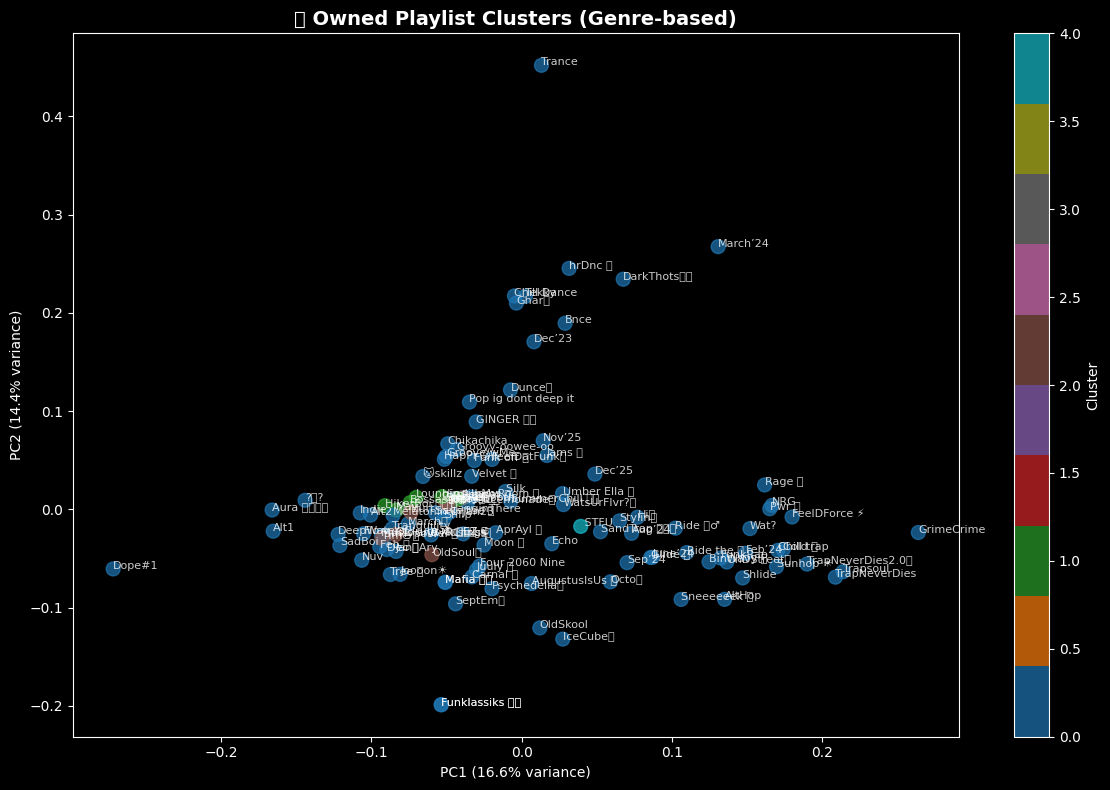

In [10]:
# Visualize clusters with PCA
if len(playlist_ids_filtered) >= 3 and len(all_genres) >= 2:
    n_components = min(2, X_filtered.shape[1])
    pca = PCA(n_components=n_components)
    X_2d = pca.fit_transform(X_filtered)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1] if n_components > 1 else np.zeros(len(X_2d)), 
                        c=cluster_labels, cmap='tab10', s=100, alpha=0.7)
    
    # Add labels
    for i, pid in enumerate(playlist_ids_filtered):
        name = playlist_names.get(pid, "")[:20]
        y_val = X_2d[i, 1] if n_components > 1 else 0
        ax.annotate(name, (X_2d[i, 0], y_val), fontsize=8, alpha=0.8)
    
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    if n_components > 1:
        ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    ax.set_title("🔗 Owned Playlist Clusters (Genre-based)", fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Cluster')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Not enough data for PCA visualization")

## 6️⃣ Your Taste Profile

/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/2597432712.py:49: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/t5/pfc67fz125q3l2d_jvn8xh2c0000gq/T/ipykernel_51187/2597432712.py:49: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/aryamaan/Desktop/Projects/spotim8_repo/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aryamaan/Desktop/Projects/spotim8_repo/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


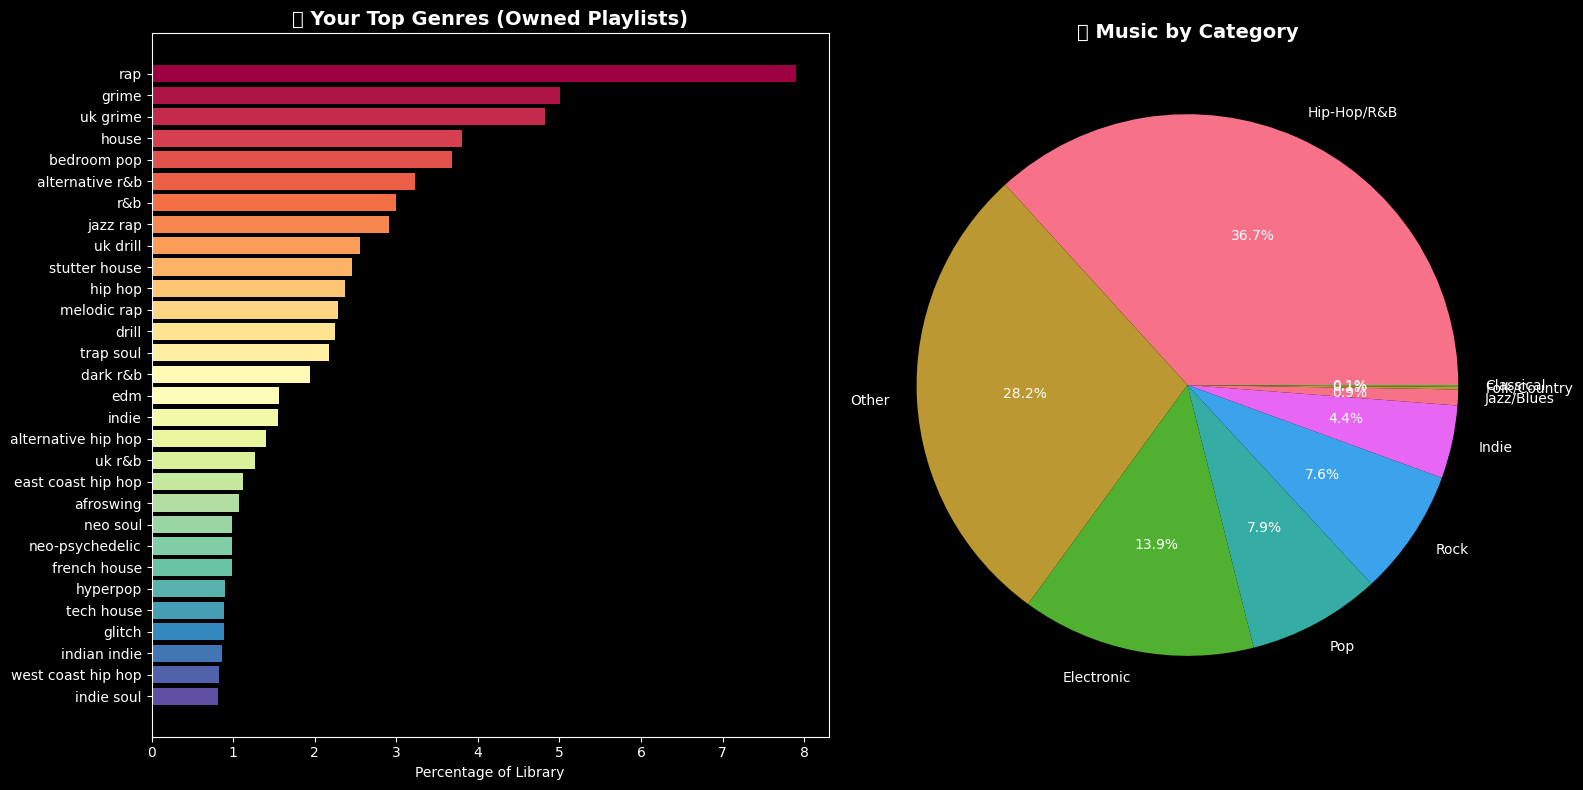


       👤 YOUR TASTE PROFILE (OWNED PLAYLISTS)

🎸 Dominant genre: rap
📊 Genre diversity: 311 unique genres

🏆 Top 5 genres:
   1. rap (7.9%)
   2. grime (5.0%)
   3. uk grime (4.8%)
   4. house (3.8%)
   5. bedroom pop (3.7%)


In [11]:
# Aggregate all genres across owned playlists
all_library_genres = Counter()
for genres in playlist_genre_profiles.values():
    all_library_genres.update(genres)

if all_library_genres:
    total_tags = sum(all_library_genres.values())
    top_genres_df = pd.DataFrame(all_library_genres.most_common(30), columns=["genre", "count"])
    top_genres_df["percentage"] = top_genres_df["count"] / total_tags * 100

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Bar chart
    colors = plt.cm.Spectral(np.linspace(0, 1, len(top_genres_df)))
    axes[0].barh(top_genres_df["genre"], top_genres_df["percentage"], color=colors)
    axes[0].set_xlabel("Percentage of Library")
    axes[0].set_title("🎸 Your Top Genres (Owned Playlists)", fontsize=14, fontweight='bold')
    axes[0].invert_yaxis()

    # Category pie chart
    category_keywords = {
        "Rock": ["rock", "metal", "punk", "grunge", "alternative"],
        "Pop": ["pop", "dance pop", "synth"],
        "Hip-Hop/R&B": ["hip hop", "rap", "r&b", "soul", "funk"],
        "Electronic": ["electronic", "edm", "house", "techno", "trance"],
        "Indie": ["indie", "bedroom", "lo-fi"],
        "Folk/Country": ["folk", "country", "americana"],
        "Jazz/Blues": ["jazz", "blues"],
        "Classical": ["classical", "orchestra", "piano"],
    }

    category_counts = defaultdict(int)
    for genre, count in all_library_genres.items():
        categorized = False
        for category, keywords in category_keywords.items():
            if any(kw in genre.lower() for kw in keywords):
                category_counts[category] += count
                categorized = True
                break
        if not categorized:
            category_counts["Other"] += count

    cat_df = pd.DataFrame(list(category_counts.items()), columns=["category", "count"])
    cat_df = cat_df.sort_values("count", ascending=False)
    axes[1].pie(cat_df["count"], labels=cat_df["category"], autopct='%1.1f%%')
    axes[1].set_title("🎵 Music by Category", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "="*60)
    print("       👤 YOUR TASTE PROFILE (OWNED PLAYLISTS)")
    print("="*60)
    print(f"\n🎸 Dominant genre: {top_genres_df.iloc[0]['genre']}")
    print(f"📊 Genre diversity: {len(all_library_genres)} unique genres")
    print(f"\n🏆 Top 5 genres:")
    for i, row in top_genres_df.head(5).iterrows():
        print(f"   {i+1}. {row['genre']} ({row['percentage']:.1f}%)")
    print("="*60)
else:
    print("⚠️ No genre data available")

## 7️⃣ Interactive Playlist Explorer

In [12]:
def analyze_playlist(playlist_name):
    """Complete analysis of a specific owned playlist."""
    pid = playlists[playlists["name"] == playlist_name]["playlist_id"]
    if len(pid) == 0:
        print(f"❌ Playlist '{playlist_name}' not found in owned playlists")
        return
    
    pid = pid.iloc[0]
    pl_info = playlists[playlists["playlist_id"] == pid].iloc[0]
    pl_tracks = playlist_tracks[playlist_tracks["playlist_id"] == pid]
    pl_track_info = pl_tracks.merge(tracks, on="track_id")
    
    print("=" * 60)
    print(f"🎵 PLAYLIST ANALYSIS: {playlist_name}")
    print("=" * 60)
    
    # Basic stats
    print(f"\n📊 STATS:")
    print(f"   • Tracks: {len(pl_tracks)}")
    if len(pl_track_info) > 0:
        total_min = pl_track_info["duration_ms"].sum() / 60000
        print(f"   • Duration: {total_min:.0f} min ({total_min/60:.1f} hrs)")
        print(f"   • Avg popularity: {pl_track_info['popularity'].mean():.0f}/100")
    
    # Top genres
    genres = playlist_genre_profiles.get(pid, Counter())
    if genres:
        print(f"\n🎸 TOP GENRES:")
        for genre, _ in genres.most_common(5):
            print(f"   • {genre}")
    
    # Similar playlists
    find_similar_playlists(playlist_name, top_n=3)
    print("\n" + "=" * 60)

# List all owned playlists
print("📂 YOUR OWNED PLAYLISTS:")
for i, (_, row) in enumerate(playlists.nlargest(15, "track_count").iterrows()):
    print(f"   {i+1}. {row['name']} ({row['track_count']} tracks)")

print("\n💡 Run: analyze_playlist('playlist name') for details")

📂 YOUR OWNED PLAYLISTS:
   1. SandTrap 🏝️🇹🇭 (980 tracks)
   2. Sunhop ☀️ (792 tracks)
   3. TrapNeverDies2.0👊 (722 tracks)
   4. Hi🍀 (712 tracks)
   5. TrapNeverDies (700 tracks)
   6. AltHop (597 tracks)
   7. Ride 🚴‍♂️ (579 tracks)
   8. Stylin🤙 (570 tracks)
   9. Chill trap (514 tracks)
   10. Echo (513 tracks)
   11. WatsUrFlvr?🍦 (502 tracks)
   12. FunkRap (452 tracks)
   13. IcedLemonade🍋 (446 tracks)
   14. Moon 🌗 (438 tracks)
   15. FeelDForce ⚡️ (435 tracks)

💡 Run: analyze_playlist('playlist name') for details


In [13]:
playlists[playlists.name.str.contains("Dec")]

,playlist_id,name,description,public,collaborative,snapshot_id,track_count,owner_id,owner_name,is_owned,is_liked_songs,uri
2,7jtCQ2nSqq7RcWjN7MV6Ij,Dec’25,,True,False,AAAAcjLEd41U4X055i7vm8V5vObl3OtH,112,31iol2qamank24owygxo7kpq533y,AJ,True,False,spotify:playlist:7jtCQ2nSqq7RcWjN7MV6Ij
158,2vbb7JOSSoInp6jth0rhDk,Dec’23,,True,False,AAAAH/e5f+Go6Lm87l42B+0slpa/7KNI,28,31iol2qamank24owygxo7kpq533y,AJ,True,False,spotify:playlist:2vbb7JOSSoInp6jth0rhDk
508,7BeZk2o8jJAKR0XWAi7jh3,Dec 🥶,,True,False,AAAAXFDNXDIYSrwi4vRYpJtSDewFdBIP,90,31iol2qamank24owygxo7kpq533y,AJ,True,False,spotify:playlist:7BeZk2o8jJAKR0XWAi7jh3


In [14]:
# Example: analyze a specific playlist
# Uncomment and change the playlist name:

analyze_playlist("Nov’25")

🎵 PLAYLIST ANALYSIS: Nov’25

📊 STATS:
   • Tracks: 382
   • Duration: 1339 min (22.3 hrs)
   • Avg popularity: 68/100

🎸 TOP GENRES:
   • house
   • rap
   • stutter house
   • edm
   • jazz rap


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

---

## ✅ Analysis Complete!

**Next:** Try `04_liked_songs_monthly_playlists.ipynb` to split your liked songs into monthly playlists.